# Install packages
AgenticTrader

In [131]:
%%capture --no-stderr
!pip install -q langchain_google_genai langchain_core langchain_community tavily-python pydantic
%pip install --quiet -U langgraph

# Import packages

In [132]:
from pydantic import BaseModel
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage

 # Set up authentication keys

In [133]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')

In [134]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    api_key = GEMINI_API_KEY,
    temperature = 0)

In [135]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6452f33e-ec0d-4eaa-9939-5a3f3c72cc20-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [136]:
messages = [
    HumanMessage(content="Hi", name="Human Student"),
    AIMessage(content='Hi! How can I help you today? \n', name="AI Assistant"),
    HumanMessage(content="What is LangChain?", name="Human Student"),
    AIMessage(content='LangChain is a framework for developing applications powered by language models.', name="AI Assistant"),
    HumanMessage(content="How can I learn", name="Human Student"),
    ]

response = llm.invoke(messages)
messages.append(response)

# for message in messages:
#   message.pretty_print()

# State

First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [137]:
class learning_state(BaseModel):
  prompt : str

In [138]:
# prompt: create an example from above LearningState
state: learning_state = learning_state(prompt = "hello from world")
print(state)
print(state.prompt +" I am")
print(state)
print(type(state))

prompt='hello from world'
hello from world I am
prompt='hello from world'
<class '__main__.learning_state'>


# Nodes

Nodes are just Python functions.

The first positional argument is the state (a Pydantic model).

Since the state is a Pydantic model, nodes can access fields like: state.graph_state.

Each node returns a new instance of the state with an updated graph_state value.

By default, this new value replaces the old one.

In [139]:
# For TypedDict

# def node_1(state: learning_state) -> learning_state:
#   print("---node 1 state ---")
#   return {"prompt" : state['prompt'] + "i am"}

# def node_2(state: learning_state) -> learning_state:
#   print("---node 2 state ---")
#   return {"prompt" : state['prompt'] + "happy"}

# For pydantic

def node_1(state: learning_state) -> learning_state:
    print("---node 1 state ---")
    return learning_state(prompt=state.prompt + " i am")

def node_2(state: learning_state) -> learning_state:
    print("---node 2 state ---")
    return learning_state(prompt=state.prompt + " happy")


# Edges
Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

# Graph Construction
Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

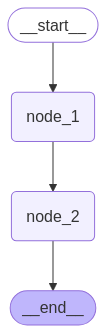

In [140]:
# Build graph
builder: StateGraph = StateGraph(state_schema=learning_state)

# Nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Simples Edges Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


# Graph Invocation
The compiled graph implements the runnable protocol.

This provides a standard way to execute LangChain components.

invoke is one of the standard methods in this interface.

The input is a dictionary {"graph_state": "Hi, this is lance."}, which sets the initial value for our graph state dict.

When invoke is called, the graph starts execution from the START node.

It progresses through the defined nodes (node_1, node_2, node_3) in order.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

In [141]:
graph.invoke({"prompt" : "Hi"})

---node 1 state ---
---node 2 state ---


{'prompt': 'Hi i am happy'}

# Conditional Edges
Conditional Edges are used want to optionally route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [156]:
class learning_state(BaseModel):
    prompt: str

def node_1(state: learning_state) -> learning_state:
    print("---node 1 state ---")
    return learning_state(prompt=state.prompt + " i am")

def node_2(state: learning_state) -> learning_state:
    print("---node 2 state ---")
    return learning_state(prompt=state.prompt + " happy")

def node_3(state: learning_state) -> learning_state:
    print("---node 3 state ---")
    return learning_state(prompt=state.prompt + " sad")

In [160]:
import random
from typing import Literal

def decide_mood(state: learning_state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state.prompt

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

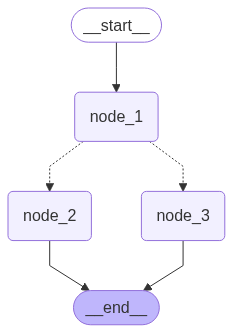

In [161]:
# Build Graph
builder : StateGraph = StateGraph(learning_state)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


graph : CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [172]:
graph.invoke({"prompt": "Hi, this is Lance."})

---node 1 state ---
---node 2 state ---


{'prompt': 'Hi, this is Lance. i am happy'}

# Messages
Chat models can use messages, which capture different roles within a conversation.

LangChain supports various message types, including HumanMessage, AIMessage, SystemMessage, and ToolMessage.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

content - content of the message
name - optionally, a message author
response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

# Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).